# Análise de Dados 
Utilizaremos dados coletados do `ESP32` e do Acelerômetro `MPU6050` para tentarmos identificar em quais locais houve uma passada do usuário e alguma forma de aplicarmos um data smoothing algorithm para termos ainda mais precisão e retiramos a chance de captação de outliers e falsos positivos.


In [24]:
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
%matplotlib inline

# Read the csv file
data_file = pd.read_csv("data.csv", names=['Raw_Data', 'Slav_Smoothing'])
data_file 

,Raw_Data,Slav_Smoothing
0,0.0,-0.0
1,0.0,-0.0
2,0.0,-0.0
3,0.0,-0.0
4,0.0,-0.0
...,...,...
11449,0.0,0.0
11450,0.0,0.0
11451,0.0,0.0
11452,0.0,0.0


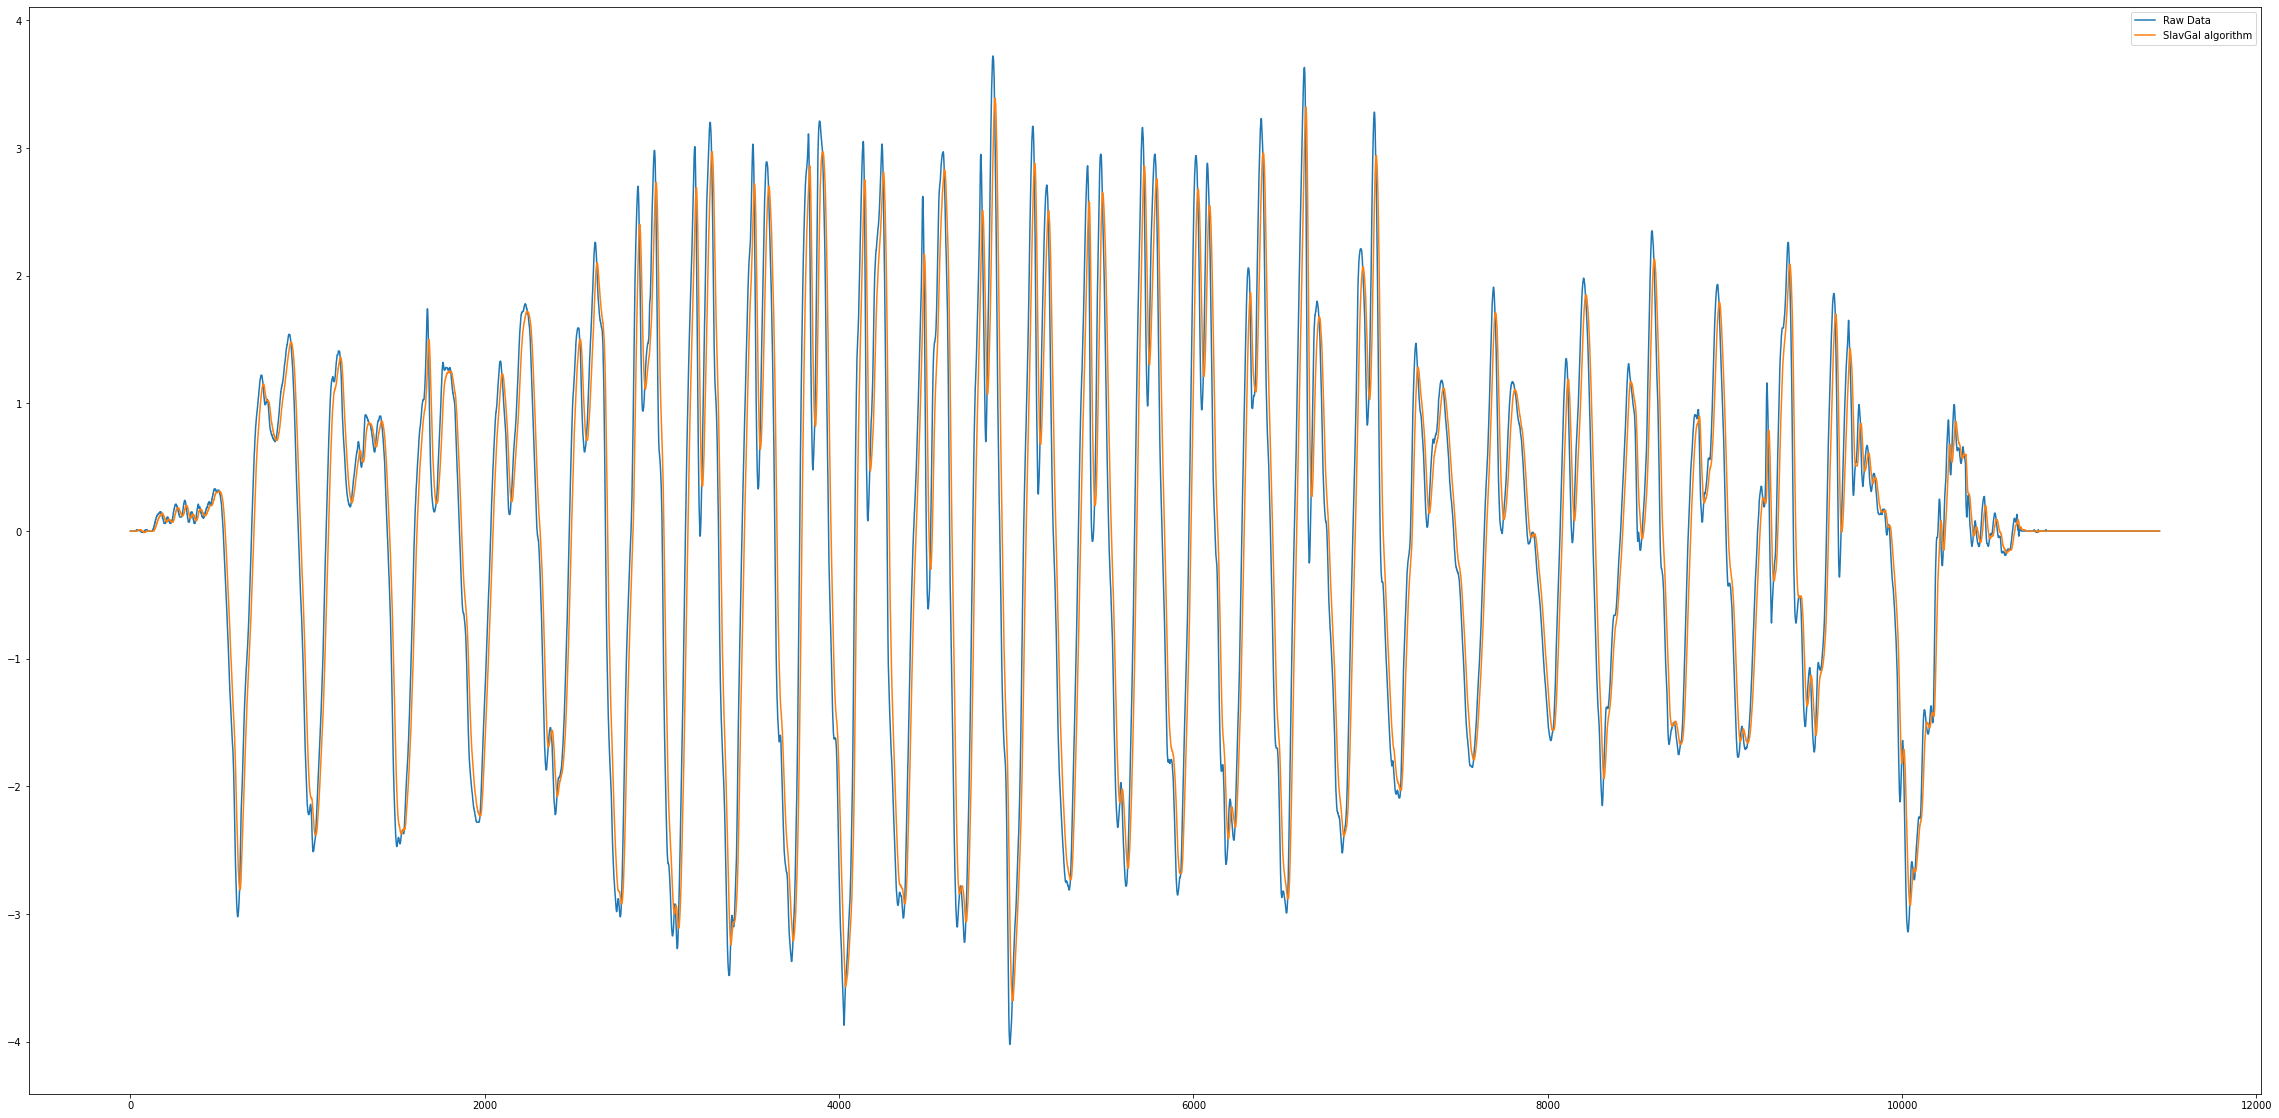

In [22]:
# Create an x axis of 1 second for every datapoint 
time = [s for s in range(len(data_file.index))]

# plot both the raw data and Slav smoothed data 
plt.figure(figsize=(40,20))
plt.plot(time,data_file.Raw_Data,label='Raw Data')
plt.plot(time, data_file.Slav_Smoothing, label='SlavGal algorithm')
plt.legend()
plt.show()


## Implementando o Gaussian Smoothing Algorithm
$$G(x) = \frac{1}{\sqrt{2\pi} \sigma} e^{-\frac{x^2}{2\sigma^{2}}}$$

Onde $\sigma$ é a standert deviation 

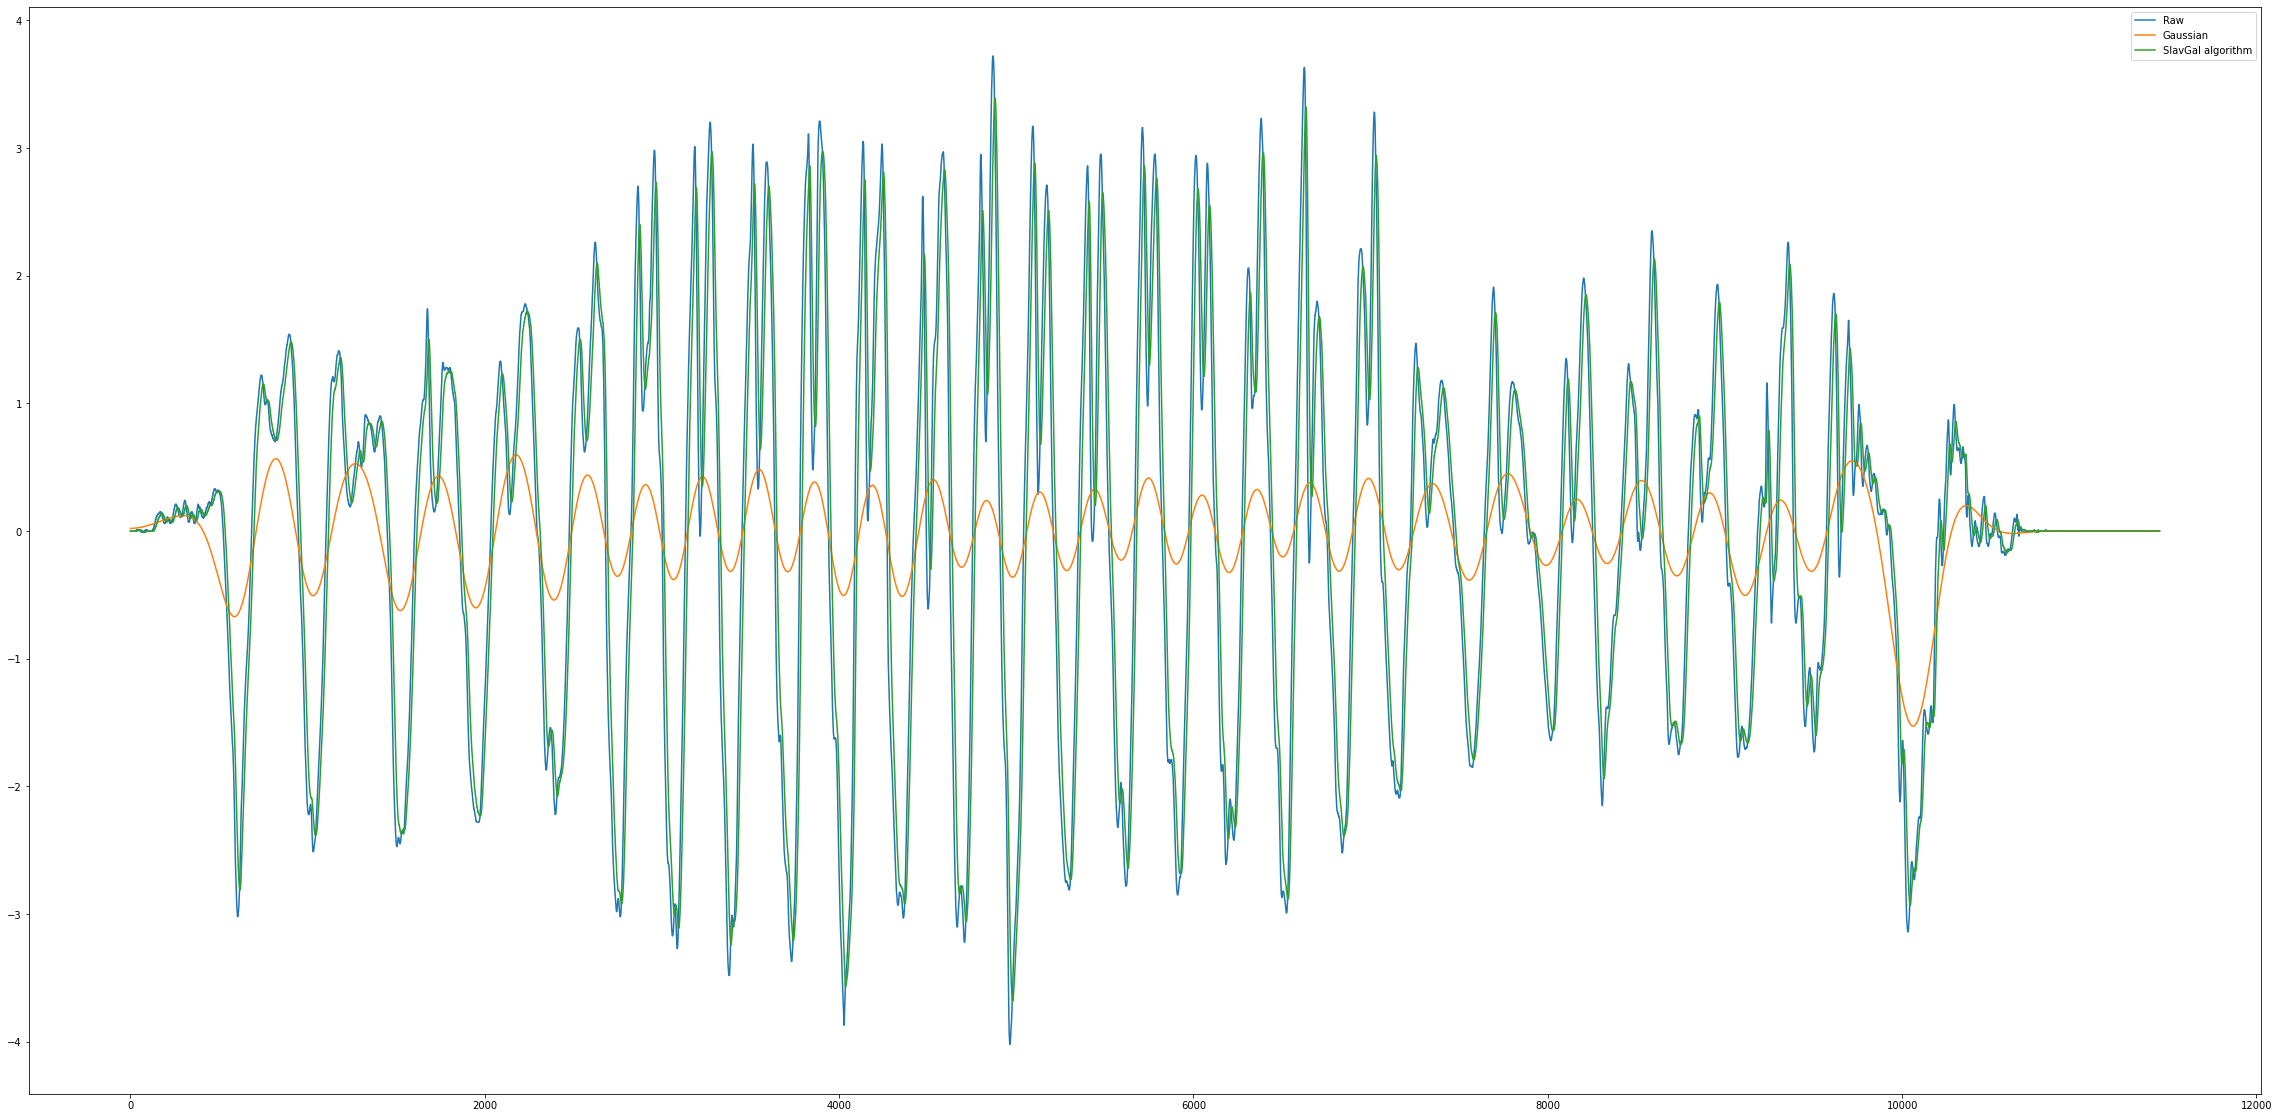

In [38]:
gaussian_data = data_file.Raw_Data
gaussian_data = gaussian_filter(gaussian_data,sigma=100)

plt.figure(figsize=(40,20))
plt.plot(time,data_file.Raw_Data, label = "Raw")
plt.plot(time, gaussian_data, label="Gaussian")
plt.plot(time, data_file.Slav_Smoothing, label='SlavGal algorithm')

plt.legend()
plt.show()

## Algorithm Analysis conclusion

Vimos que é necessário a utilização do algorítmo de Gauss para que sejam cmputados somente os máximo reais, retirando assim qualquer barulho ou falsos positivos durante a contagem de passos dados. 

## Próximos Passos 
O próximo passo é a implementação matemática pura da teoria gaussiana em Python para POC, após a averiguação do funcionamento e paridade com os resultados encontrados pela função do módulo SciPy, passaremos para a implementação na linguagem c++ (utilizada no ESP32).

In [75]:
from math import sqrt, exp, pi 

# The kernel is a set of points used to later on smooth the raw sensor data
def create_kernel(sigma, position, x_vals):
    kernel = []

    # Populate the kernel list 
    for x_val in x_vals:
        kernel.append(np.exp(-(x_val - position) ** 2 / (2 * sigma ** 2)))

    # Devide all the elements by the sum of the whole kernel to avoid errors 
    k_sum = sum(kernel)
    for k in kernel:
        k = k/k_sum
    return kernel


def calculate_smoothed_data(window, position, raw_data, x_axis):
    # Get the kernel 
    kernel = create_kernel(sigma=100,position=position,x_vals=x_axis)

    # Subdevide both the kernel and raw data in the position to the desired window 
    #calculate the number of adjecent number in each side based on the window
    # print(window)
    n_adjecent = int((window-1)/2)
    print('numero de adjasentes:', n_adjecent)
    y_window = raw_data[position-n_adjecent:position+n_adjecent]
    print('y_window',y_window)
    k_window = kernel[position-n_adjecent:position+n_adjecent]

    # We now multiple element 0 on the y by the element 0 on the k and then add the product of element 1 on y by the element 1 on k and so on 
    sum_data = 0
    for k,y in zip(k_window,y_window):
        sum_data+=(k*y)
    
    smoothed_data = sum_data



In [76]:
gaussian_data = data_file.Raw_Data
gaussian_data = gaussian_filter(gaussian_data,sigma=100)


c_gauss = []
for x,position in enumerate(time):
    if position <=6:
        c_gauss.append(data_file.Raw_Data[position])
    else:
        data = calculate_smoothed_data(window = 5,position = position,raw_data = data_file.Raw_Data, x_axis = time)
        # print(data)
        c_gauss.append(data)

plt.figure(figsize=(40,20))
plt.plot(time,data_file.Raw_Data, label = "Raw")
# plt.plot(time, gaussian_data, label="Gaussian")
plt.plot(time, c_gauss, label="Custom Gaussian")


plt.legend()
plt.show()

2
5    0.0
6    0.0
7    0.0
8    0.0
Name: Raw_Data, dtype: float64
2
6    0.0
7    0.0
8    0.0
9    0.0
Name: Raw_Data, dtype: float64
2
7     0.0
8     0.0
9     0.0
10    0.0
Name: Raw_Data, dtype: float64
2
8     0.0
9     0.0
10    0.0
11    0.0
Name: Raw_Data, dtype: float64
2
9     0.0
10    0.0
11    0.0
12    0.0
Name: Raw_Data, dtype: float64
2
10    0.0
11    0.0
12    0.0
13   -0.0
Name: Raw_Data, dtype: float64
2
11    0.0
12    0.0
13   -0.0
14   -0.0
Name: Raw_Data, dtype: float64
2
12    0.0
13   -0.0
14   -0.0
15   -0.0
Name: Raw_Data, dtype: float64
2
13   -0.0
14   -0.0
15   -0.0
16   -0.0
Name: Raw_Data, dtype: float64
2
14   -0.0
15   -0.0
16   -0.0
17   -0.0
Name: Raw_Data, dtype: float64
2
15   -0.0
16   -0.0
17   -0.0
18   -0.0
Name: Raw_Data, dtype: float64
2
16   -0.0
17   -0.0
18   -0.0
19   -0.0
Name: Raw_Data, dtype: float64
2
17   -0.0
18   -0.0
19   -0.0
20   -0.0
Name: Raw_Data, dtype: float64
2
18   -0.0
19   -0.0
20   -0.0
21   -0.0
Name: Raw_Data, d

KeyboardInterrupt: 